# Quality Classification

Import the Required libraries

In [14]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from patsy import dmatrices
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [3]:
#Read the data
df = pd.read_csv('winequality-white.csv')
#drop the quality column - response variable
df_temp = df.drop('quality', axis=1)
#Normalize data
df_norm = (df_temp-df_temp.min())/(df_temp.max()-df_temp.min())

#quality greater than 6 is considered good, assign 1 and quality less than or equal to 6 is considered not good so assign 0
q = df['quality'].apply(lambda x: 1 if x > 6 else 0)

#concat q and df_norm
df_norm = pd.concat((df_norm, q), 1)
print(df_norm)
df=df_norm.copy()

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.307692          0.186275     0.216867        0.308282   0.106825   
1          0.240385          0.215686     0.204819        0.015337   0.118694   
2          0.413462          0.196078     0.240964        0.096626   0.121662   
3          0.326923          0.147059     0.192771        0.121166   0.145401   
4          0.326923          0.147059     0.192771        0.121166   0.145401   
...             ...               ...          ...             ...        ...   
4893       0.230769          0.127451     0.174699        0.015337   0.089021   
4894       0.269231          0.235294     0.216867        0.113497   0.112760   
4895       0.259615          0.156863     0.114458        0.009202   0.094955   
4896       0.163462          0.205882     0.180723        0.007669   0.038576   
4897       0.211538          0.127451     0.228916        0.003067   0.032641   

      free sulfur dioxide  

In [4]:
df.iloc[0]

fixed acidity           0.307692
volatile acidity        0.186275
citric acid             0.216867
residual sugar          0.308282
chlorides               0.106825
free sulfur dioxide     0.149826
total sulfur dioxide    0.373550
density                 0.267785
pH                      0.254545
sulphates               0.267442
alcohol                 0.129032
quality                 0.000000
Name: 0, dtype: float64

# Create formula for design matrices

In [5]:
formula = 'quality ~ ' + ' + '.join(['Q("'+x+'")' \
                                    for x in df.columns.values\
                                    if x != 'quality'])
print(formula)

quality ~ Q("fixed acidity") + Q("volatile acidity") + Q("citric acid") + Q("residual sugar") + Q("chlorides") + Q("free sulfur dioxide") + Q("total sulfur dioxide") + Q("density") + Q("pH") + Q("sulphates") + Q("alcohol")


In [6]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['quality'].values

# Create training and testing sets

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

# Classifiers

In [8]:
# All the models we want to test out
models = {}
models['Decision Tree'] = \
    tree.DecisionTreeClassifier(criterion='entropy')

models['Bagging'] = \
    BaggingClassifier(
        tree.DecisionTreeClassifier(criterion='entropy'),
        random_state=1)

models['Random Forest'] = \
    RandomForestClassifier(n_estimators=10,
                           random_state=1)

models['Gradient Boosting'] = \
    GradientBoostingClassifier(n_estimators=200,
                               max_depth=4,
                               random_state=1)

# Model Fitting

In [9]:
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)

Fitting Decision Tree
Fitting Bagging
Fitting Random Forest
Fitting Gradient Boosting


# Accuracy Score

In [10]:
from sklearn import metrics

accuracy_train = {}
accuracy_test = {}
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    prediction_test = model.predict(X_test)
    accuracy_test[name] = metrics.accuracy_score(y_test, prediction_test)
    
df = DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test})
df

,Training Accuracy,Test Accuracy
Decision Tree,1.000000,0.809524
Bagging,0.989498,0.852381
Random Forest,0.990665,0.860544
Gradient Boosting,0.951284,0.847619


Text(0, 0.5, 'Test accuracy')

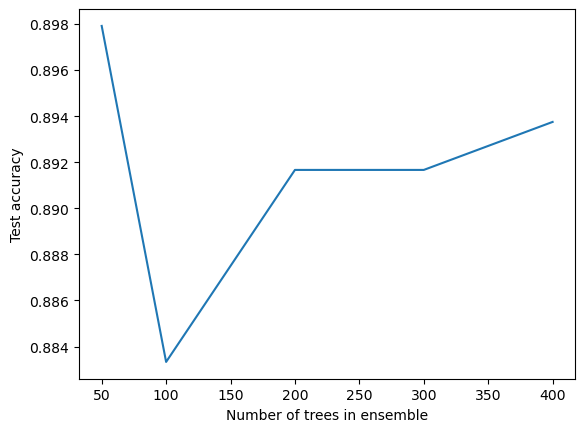

In [25]:
scores = {}
for num_trees in [50, 100, 200, 300, 400]:
    model = GradientBoostingClassifier(n_estimators=num_trees,
                                       max_depth=2,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[num_trees] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Number of trees in ensemble')
ylabel('Test accuracy')

In [ ]:
#300 trees is enough

Text(0, 0.5, 'Test accuracy')

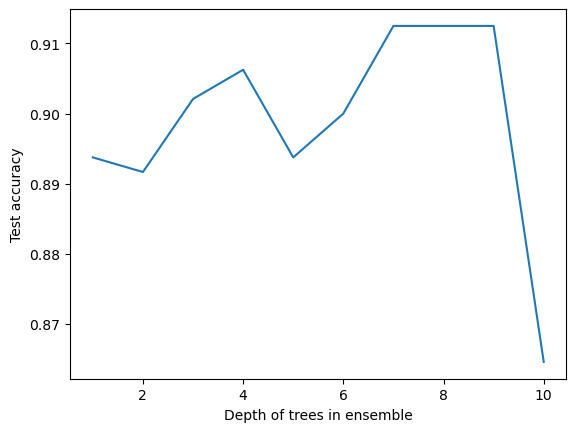

In [27]:
scores = {}
for depth in range(1, 11):
    model = GradientBoostingClassifier(n_estimators=200,
                                       max_depth=depth,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[depth] = accuracy_test
Series(scores).sort_index().plot()
xlabel('Depth of trees in ensemble')
ylabel('Test accuracy')

In [ ]:
#above graph 7 seems to be better

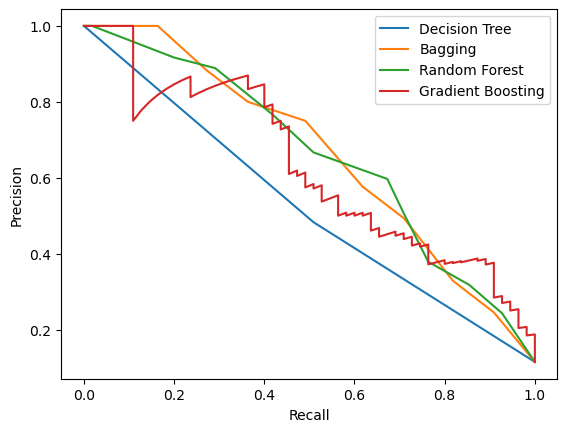

In [29]:
from sklearn.metrics import precision_recall_curve

for index, (name, model) in enumerate(models.items()):
    predictions = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, predictions[:, 1])
    plot(recall, precision, label=name)

xlabel('Recall')
ylabel('Precision')
legend(loc='best')
savefig('download')

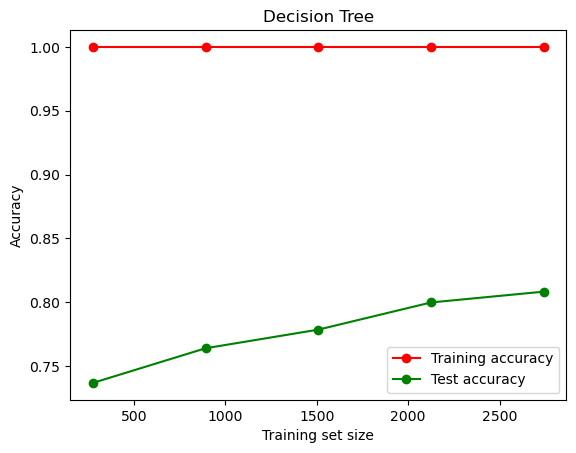

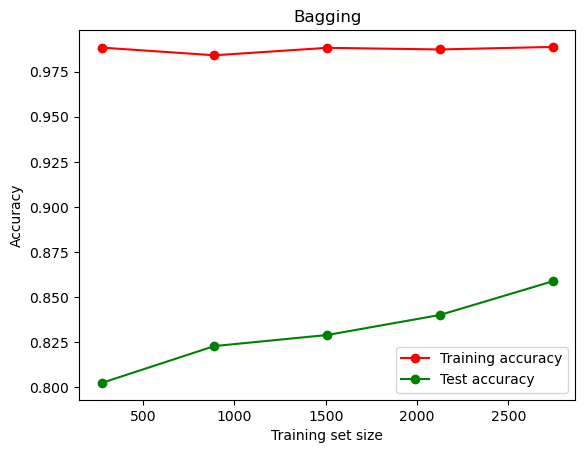

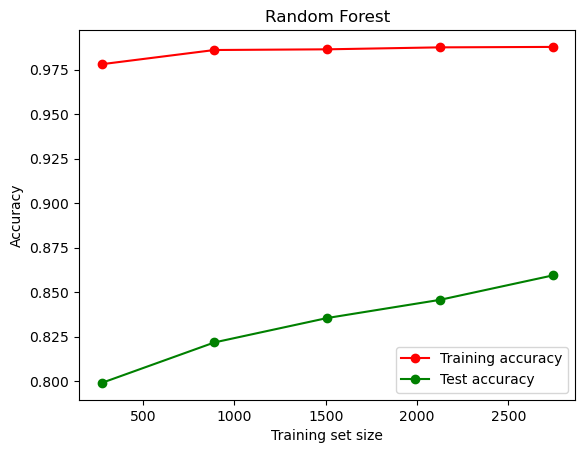

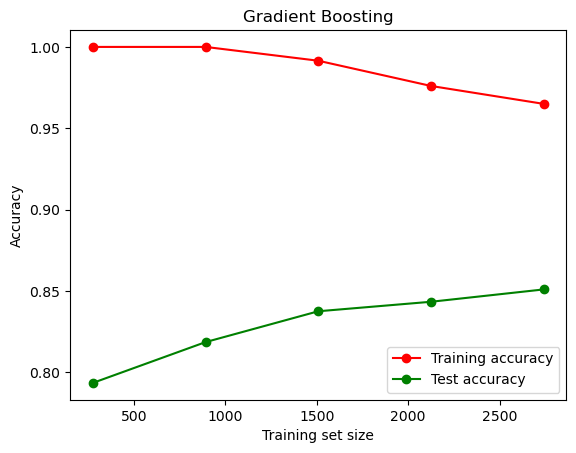

In [15]:
from sklearn.model_selection import learning_curve

for name, model in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training accuracy')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Test accuracy')
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.title(name)
    plt.show()

In [20]:
# Train the Gradient Boosting model with the best number of trees
best_num_trees = 200  # Replace this with the best number of trees you found
model = GradientBoostingClassifier(n_estimators=best_num_trees, max_depth=4, random_state=1)
model.fit(X_train, y_train)

# Get the feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the variable importance in descending order
print(feature_importance_df)

                      Feature  Importance
11               Q("alcohol")    0.331178
2       Q("volatile acidity")    0.091856
8                Q("density")    0.082320
9                     Q("pH")    0.078938
5              Q("chlorides")    0.072502
4         Q("residual sugar")    0.071958
6    Q("free sulfur dioxide")    0.071196
10             Q("sulphates")    0.056907
7   Q("total sulfur dioxide")    0.049908
3            Q("citric acid")    0.048916
1          Q("fixed acidity")    0.044320
0                   Intercept    0.000000
